In [4]:
import bisect
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt

def simple_lin_interp(x1, y1, x2, y2, x):
    slope = (y2 - y1) / float(x2 - x1)
    return slope * (x - x1) + y1
def get_neighbor(DG, node):
    try:
        neighbors = DG.successors(DG.predecessors(node)[0])
    except:
        neighbors = []
    return neighbors
def return_smoothed(points, interpolate=False):
    if len(points) < 3: return points
    from scipy.interpolate import splrep
    from scipy.interpolate import splev
    from scipy.interpolate import Akima1DInterpolator

    x, y = zip(*points)

    if interpolate:
        return points
        # return zip(x,Akima1DInterpolator(x,y)(x))

    else:
        from statsmodels.nonparametric.kernel_regression import KernelReg
        kr = KernelReg(y, x, 'c')
        x_ = []  # list(np.linspace(min(x),max(x),3))
        x_.extend(x)
        x_ = sorted(set(x_))
        y_pred, _ = kr.fit(x_)

        return zip(x_, y_pred)


        if len(points) > 2:
            w = [1] + [0.1] * (len(points) - 2) + [1]
        else:
            w = [1] * len(points)

        K = min([len(points) - 1, 3])
        spl = splrep(x, y, s=30., t=[], k=K, w=w)
        # plt.figure()
        # plt.plot(x,splev(x,spl))
        # plt.plot(x,y,'o')
        # plt.show()
        x_ = []  # list(np.linspace(min(x),max(x),3))
        x_.extend(x)
        x_ = sorted(set(x_))
        return zip(x_, splev(x_, spl))
def nx_walk(node,tree,override_list=False):
    """ iterate tree in pre-order depth-first search order """
    if override_list is not False:
        for n in override_list:
            yield n
    else:
        yield node
        for child in tree.successors(node):
            for n in nx_walk(child,tree):
                yield n



def _make_phylo_cmap():
    import collections
    import random
    def shuffle(x):
        x = list(x)
        random.shuffle(x)
        return x

    def _get_fixed_colors(subclone_key):
        # green, black, blue,purple,orange

        color_list = [[39, 140, 24],
                      [103, 200, 243],
                      [16, 49, 41],
                      [248, 139, 16],
                      [93, 119, 254],
                      [152, 22, 26],
                      [104, 236, 172],
                      [249, 142, 135],
                      [55, 18, 48],
                      [83, 82, 22],
                      [247, 36, 36],
                      [0, 79, 114],
                      [243, 65, 132],
                      [60, 185, 179],
                      [185, 177, 243],
                      [139, 34, 67],
                      [178, 41, 186],
                      [58, 146, 231],
                      [130, 159, 21],
                      [161, 91, 243],
                      [131, 61, 17],
                      [248, 75, 81],
                      [32, 75, 32],
                      [45, 109, 116],
                      [255, 169, 199],
                      [55, 179, 113],
                      [34, 42, 3],
                      [56, 121, 166],
                      [172, 60, 15],
                      [115, 76, 204],
                      [21, 61, 73],
                      [67, 21, 74],  # Additional colors, uglier and bad
                      [123, 88, 112],
                      [87, 106, 46],
                      [37, 66, 58],
                      [132, 79, 62],
                      [71, 58, 32],
                      [59, 104, 114],
                      [46, 107, 90],
                      [84, 68, 73],
                      [90, 97, 124],
                      [121, 66, 76],
                      [104, 93, 48],
                      [49, 67, 82],
                      [71, 95, 65],
                      [127, 85, 44]]

        return color_list[subclone_key]

    palette = _get_fixed_colors(slice(None, None, None))

    # Scale the RGB values to the [0, 1] range,which is the format matplotlib accepts.
    for i in range(len(palette)):
        r, g, b = palette[i]
        palette[i] = (r / 255., g / 255., b / 255.)
    from matplotlib import colors as mcolors

    phylo_cmap = mcolors.ListedColormap(palette)
    return phylo_cmap


def get_child_color(parent_color,differentiate=False):

            if differentiate:

                child_color = [min([1, 0.5 * parent_color[x] + 0.5 * parent_color[x]]) for x in range(3)]
            else:
                child_color = [min([1, 0.5 *parent_color[x] + 0.5]) for x in range(3)]



class simple_tree():

    """
    Class to allow slicing points across intervals. Intended for large mafs.
    (works for 1d data, but not arbitrary length segments)
    Similar to a BST

    Built to work for int positions, but could be re-done to work

    """

    def __init__(self, _xvals=None, _data=None, sorted_=True):

        if (_data is not None) and (_xvals is not None):
            if sorted_:
                self._xvals = _xvals
                self._data = _data
            else:  # assume sorted, but if re-sorting is nessary do it.
                self._xvals, self._data = zip(*sorted(zip(_xvals, _data), key=lambda x: x[0]))
                self._xvals=list(self._xvals)
                self._data=list(self._data)
        else:
            self._xvals = []
            self._data = []

    def __len__(self):
        return len(self._data)

    def __repr__(self):
        return str(self._data)

    def __getitem__(self, sliced):
        if type(sliced) is int or type(sliced) is float:  # if the slice is a point, return the point
            return [self._xvals[bisect.bisect_left(self._xvals, sliced)], self._data[bisect.bisect_left(self._xvals, sliced)]]
        else:  # otherwise slice from the slice object with bisection
            return zip(self._xvals[bisect.bisect_left(self._xvals, sliced.start):bisect.bisect_left(self._xvals, sliced.stop)],
                       self._data[bisect.bisect_left(self._xvals, sliced.start):bisect.bisect_left(self._xvals, sliced.stop)])

    def add(self, item):
        """
        Add an item, assumes [pos(int),value]
        Append if not sorted, else binary search for position.
        """
        try:  # will throw index error on first attempt.

            _sorted = item[0] >= self._xvals[-1]
        except IndexError:
            _sorted = True  # it is slowish to check every time if the list exists or not, but on the first try it's going to give indexerror since it's empty.

        if _sorted:  # if item is at the end we can do O(1) append.
            self._xvals.append(item[0])
            self._data.append(item[1])

        else:  # if item is not at the end, we need  O(logN) binary search, then  O(N) insert. In all O(NlogN)

            ins_idx = bisect.bisect(self._xvals, item[0])
            self._xvals.insert(ins_idx, item[0])
            self._data.insert(ins_idx, item[1])

    def append(self, item):
        """
        Append an item, assumes [pos(int),value] and item belongs at end of list!
        """
        self._data.append(item[1])
        self._xvals.append(item[0])

    def copy(self):
        return simple_tree(_xvals=self._xvals[:], _data=self._data[:], sorted_=True)  # new tree, parameters should be default but might change.

    def _re_sort(self):
        """
        This function shouldn't need to be called. Re-sort the object.
        """
        self._xvals, self._data = zip(*sorted(zip(self._xvals, self._data), key=lambda x: x[0]))


In [137]:
def make_fish(cluster_raw_ccfs,graph=None, root_node = 0, wbc=tuple(), add_wbc=simple_tree(), sample_labels=tuple(), times=tuple(), interp="smooth",smooth_hack=False,scatter=False):

    phylo_cmap = _make_phylo_cmap()

    # plt.figure(figsize=(20,4))
    import numpy as np
    import matplotlib.pyplot as plt


    n_timepoints = len(cluster_raw_ccfs[1])
    n_clusters= len(cluster_raw_ccfs)

    if len(wbc) == 0:
        wbc = np.repeat(1,n_timepoints)
    if len(times) == 0:
        times = list(range(1,n_timepoints+1))

    if len(add_wbc) == 0:
        add_wbc=simple_tree(_xvals=times,_data=wbc,sorted_=False)
    elif smooth_hack:
        for point in zip(times,wbc):
            add_wbc.add(point)

    if graph is None:
        DG=nx.DiGraph()
        for cluster in cluster_raw_ccfs.keys():
            DG.add_edge(None,cluster)
        override_list = cluster_raw_ccfs.keys()
    else:
        DG=graph
        override_list = False


    na = np.array

    fig = plt.gcf()
    ax = plt.gca()  # fig.add_subplot(111)

    plot_floor = [0] * n_timepoints
    plot_floor_by_parent = {x: 0 for x in DG.nodes()}

    cluster_colors = {}



    for cluster_idx in nx_walk(root_node, DG,override_list=override_list):

        phylo_adj_ccfs = []

        cluster = []
        new_times = []

        if len(add_wbc) > 0:

            min_time = min(add_wbc._xvals)
            max_time = max(add_wbc._xvals)
        else:
            min_time = min(times)
            max_time = max(times)






        _ccfs_for_interp = []
        _ccfs_adj_for_interp = []
        for idx, time_point in enumerate(cluster_raw_ccfs[cluster_idx]):
            current_point = time_point
            adj_current_point = time_point
            for child in DG.successors(cluster_idx):
#                 print ('child:',child,cluster_raw_ccfs[child][idx])
                adj_current_point -= cluster_raw_ccfs[child][idx]
            adj_current_point = max([adj_current_point, 0])
            _ccfs_for_interp.append(current_point)
            _ccfs_adj_for_interp.append(adj_current_point)

        ##enumerate ccf across timepoints from michi
        for idx, time_point in enumerate(cluster_raw_ccfs[cluster_idx]):
            current_point = time_point
            adj_current_point = time_point
            for child in DG.successors(cluster_idx):
                adj_current_point -= cluster_raw_ccfs[child][idx]
            adj_current_point = max([adj_current_point, 0])

#             print('cluster', cluster_idx, 'idx:', idx)
            if idx == 0:
                for wbc_point in return_smoothed(add_wbc[0:times[idx + 1]],interpolate= interp == "linear"):
                    if wbc_point[0] in new_times: continue
                    cluster.append(wbc_point[1] * current_point)
                    new_times.append(wbc_point[0])
                    phylo_adj_ccfs.append(wbc_point[1] * adj_current_point)
                    
            elif idx == len(cluster_raw_ccfs[cluster_idx]) - 1:
                for wbc_point in return_smoothed(add_wbc[times[idx]:max_time],interpolate= interp == "linear"):
                    if wbc_point[0] in new_times: continue
                    cluster.append(wbc_point[1] * current_point)
                    new_times.append(wbc_point[0])
                    phylo_adj_ccfs.append(wbc_point[1] * adj_current_point)

                if times[idx] > new_times[-1]:
                    cluster.append(wbc[idx] * current_point)
                    new_times.append(times[idx])
                    phylo_adj_ccfs.append(wbc[idx] * adj_current_point)

            else:
                for wbc_point in return_smoothed(add_wbc[times[idx]:times[idx + 1]],interpolate= interp == "linear"):
                    if wbc_point[0] in new_times: continue

                    cluster.append(wbc_point[1] * simple_lin_interp(times[idx], _ccfs_for_interp[idx], times[idx + 1], _ccfs_for_interp[idx + 1], wbc_point[0]))
                    # cluster.append(wbc_point[1]*current_point)
                    new_times.append(wbc_point[0])
                    phylo_adj_ccfs.append(wbc_point[1] * simple_lin_interp(times[idx], _ccfs_adj_for_interp[idx], times[idx + 1], _ccfs_adj_for_interp[idx + 1], wbc_point[0]))

#             print(phylo_adj_ccfs)
                    # current_point=min([current_point,1])


                    # phylo_adj_ccfs.append(current_point)
        if plot_floor_by_parent[cluster_idx] == 0:
            plot_floor_by_parent = {x: [0] * len(cluster) for x in DG.nodes()}

        top_line_pre_inter = na(plot_floor_by_parent[cluster_idx]) + na(cluster)  # /2.
#         print ('top_line_pre_inter',top_line_pre_inter)
        
        bottom_line_pre_inter = na(plot_floor_by_parent[cluster_idx])  # - na(cluster)/2.
#         print ('bottom_line_pre_inter',bottom_line_pre_inter)
        
        intelligent_color = phylo_cmap.colors[cluster_idx]

        
        cluster_colors[cluster_idx] = intelligent_color
        if interp == "smooth":
            from scipy.interpolate import Akima1DInterpolator 

            interp_x_vals = sorted(list(np.linspace(min(new_times), max(new_times), 501)) + new_times)
            weights_for_smooth = []
            for point in new_times:
                if point in times:
                    weights_for_smooth.append(0.5)
                elif point < max(times):
                    weights_for_smooth.append(0.5)
                else:
                    weights_for_smooth.append(1)

            top_line_inter = np.abs(Akima1DInterpolator(new_times, top_line_pre_inter)(interp_x_vals))  
#             print ('top_line_inter',top_line_inter)
            
            bottom_line_inter = np.abs(Akima1DInterpolator(new_times, bottom_line_pre_inter)(interp_x_vals))
#             print ('bottom_line_inter',bottom_line_inter)

            plt.fill_between(interp_x_vals, bottom_line_inter, top_line_inter, color=intelligent_color, label = cluster_idx)
            # if max(new_times)>max(times):
            #    plt.fill_between(new_times[new_times>max(times)], top_line_pre_inter[new_times>max(times)], bottom_line_pre_inter[new_times>max(times)], color=intelligent_color)


        elif interp == "linear":
            plt.fill_between(new_times, top_line_pre_inter, bottom_line_pre_inter, color=intelligent_color)

        # plt.show()

        for x in range(len(cluster)):
            for key in plot_floor_by_parent:
                if key in nx_walk(cluster_idx, DG):
                    # if key == cluster_idx:continue
                    plot_floor_by_parent[key][x] += phylo_adj_ccfs[x] / 2.  # *wbc[x]
                else:  # key in get_neighbor(DG,cluster_idx):
                    # if key == cluster_idx:continue
                    plot_floor_by_parent[key][x] += phylo_adj_ccfs[x]  # wbc[x]
#         print plot_floor_by_parent
        
#     plt.gca().set_xticks(times)
    # plt.gca().set_xticklabels(labels, rotation="vertical")
    if len(sample_labels) > 0:
        for time, label in zip(*[times, sample_labels]):
            plt.axvline(x=time,ymin=0,ls="dashed", lw=2)

    ## plt.savefig("_"+"_"+interp+"_"+"clean.pdf")
    if scatter:
        plt.scatter(add_wbc._xvals[:-1], add_wbc._data[:-1], marker='.', color="black", alpha=0.5)
        
    plt.xlabel("Time (Days from Diagnosis)")
    #plt.xlim([0,16])
    # plt.savefig(indiv+"_"+phylosheet+"_"+interp+"_"+"scatter.pdf")



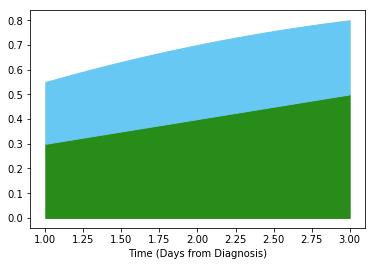

In [138]:
#Just draw clusters with size
CCF_example={0:[0.3,0.4,0.5], 1:[0.25,0.3,0.3]} #Dictionary by cluster

make_fish(CCF_example, root_node= 0)

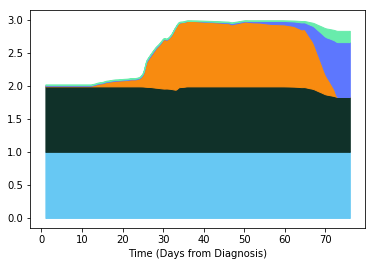

In [98]:
#Just draw clusters with size
CCF_example={0:[0.3,0.4,0.5], 1:[0.25,0.3,0.3]} #Dictionary by cluster

# CCF = {1: [2.0001, 2.170312765957447, 2.340525531914894, 2.5107382978723405, 2.851163829787234, 3.0213765957446808, 3.1976683890577506, 3.404355319148936, 3.4894617021276595, 3.659674468085106, 3.8298872340425527, 4.0001, 3.6957521739130432, 3.208795652173913, 2.965317391304348, 2.478360869565217, 2.234882608695652, 1.9653173913043473, 1.878360869565217, 1.7479260869565216, 1.6348826086956518, 1.4087956521739127, 1.3827086956521737, 1.0001, 0.8177100628930818, 0.2516723270440251, 0.0001, 0.21152857142857143, 0.37152857142857143, 0.5601, 0.5715285714285714, 0.7315285714285714, 1.0001, 0.22458979591836736, 0.1429571428571429, 0.0001, 0.023909523809523808, 0.07152857142857143, 0.19057619047619045, 0.3334333333333333, 0.5001, 0.6429571428571428, 0.8334333333333332, 1.0001, 1.1667666666666665, 1.3096238095238095, 2.0001, 3.0001, 4.0001, 5.0001, 4.111211111111111, 3.0001, 2.8038383177570094, 2.4113149532710283, 1.6262682242990656, 0.8412214953271029, 0.44869813084112176, 0.22439906542056098, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001], 2: [95.0001, 94.82988723404256, 94.65967446808511, 94.48946170212766, 94.14903617021277, 93.97882340425532, 93.80253161094225, 93.59584468085107, 93.51073829787235, 93.34052553191489, 93.17031276595745, 93.0001, 92.08705652173913, 90.62618695652174, 89.89575217391305, 88.43488260869566, 87.70444782608696, 86.89575217391305, 86.63488260869566, 86.24357826086957, 85.90444782608697, 85.22618695652174, 85.14792608695653, 84.0001, 77.61645220125786, 57.805131446540884, 49.0001, 39.90867142857143, 33.02867142857143, 24.9201, 24.42867142857143, 17.54867142857143, 6.0001, 1.347038775510204, 0.8572428571428574, 0.0001, 0.023909523809523808, 0.07152857142857143, 0.19057619047619045, 0.3334333333333333, 0.5001, 0.6429571428571428, 0.8334333333333332, 1.0001, 1.1667666666666665, 1.3096238095238095, 2.0001, 1.3334333333333337, 0.666766666666667, 0.0001, 0.0001, 0.0001, 0.06552056074766355, 0.19636168224299064, 0.4580439252336448, 0.719726168224299, 0.8505672897196261, 0.925333644859813, 1.0001, 1.024490243902439, 1.0976609756097562, 1.170831707317073, 1.3415634146341464, 1.5366853658536586, 1.6342463414634145, 2.3171731707317074, 3.0001, 5.333433333333334, 7.666766666666666, 10.0001, 7.846253846153846, 5.692407692307691, 3.0001, 3.0001, 3.0001, 3.0001], 3: [1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 2.217491304347826, 4.165317391304348, 5.1392304347826085, 7.087056521739131, 8.060969565217391, 9.13923043478261, 9.487056521739131, 10.008795652173912, 10.460969565217392, 11.365317391304348, 11.469665217391304, 13.0001, 19.566137735849058, 39.94349622641509, 49.0001, 57.24581428571429, 63.48581428571429, 70.8401, 71.28581428571428, 77.52581428571429, 88.0001, 91.10214081632654, 91.42867142857143, 92.0001, 92.02390952380952, 92.07152857142857, 92.1905761904762, 92.33343333333333, 92.5001, 92.64295714285714, 92.83343333333333, 93.0001, 93.16676666666667, 93.30962380952381, 94.0001, 93.66676666666667, 93.33343333333333, 93.0001, 93.88898888888889, 95.0001, 94.93467943925233, 94.80383831775701, 94.54215607476635, 94.28047383177571, 94.14963271028037, 94.07486635514019, 94.0001, 93.63424634146342, 92.53668536585366, 91.4391243902439, 88.8781487804878, 85.95131951219513, 84.48790487804878, 74.2440024390244, 64.0001, 50.666766666666675, 37.33343333333334, 24.0001, 18.153946153846153, 12.307792307692306, 5.0001, 3.714385714285714, 2.3334333333333332, 1.0001], 4: [1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.6343857142857143, 2.1143857142857145, 2.6801000000000004, 2.714385714285714, 3.1943857142857146, 4.0001, 5.551120408163265, 5.714385714285714, 6.0001, 5.9405761904761905, 5.821528571428571, 5.5239095238095235, 5.166766666666667, 4.7501, 4.392957142857143, 3.9167666666666667, 3.5000999999999998, 3.0834333333333332, 2.726290476190476, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.1963616822429906, 1.588885046728972, 2.3739317757009344, 3.1589785046728975, 3.551501869158878, 3.775800934579439, 4.0001, 4.292782926829268, 5.170831707317073, 6.048880487804878, 8.097660975609756, 10.4391243902439, 11.609856097560975, 19.804978048780487, 28.0001, 40.33343333333333, 52.66676666666666, 65.0001, 73.0001, 81.0001, 91.0001, 92.60724285714286, 94.33343333333333, 96.0001], 6: [1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.0001, 1.048880487804878, 1.1952219512195121, 1.3415634146341464, 1.6830268292682926, 2.073270731707317, 2.2683926829268293, 3.634246341463415, 5.0001, 3.6667666666666667, 2.3334333333333332, 1.0001, 1.0001, 1.0001, 1.0001, 0.6786714285714286, 0.33343333333333336, 0.0001]}

CCF = {1: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 2: [0.99,
  0.99,
  0.99,
  0.98,
  0.94,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.95,
  0.8699999999999999,
  0.83,
  0.83],
 3: [0.01,
  0.01,
  0.12,
  0.48,
  0.94,
  0.99,
  0.94,
  0.98,
  0.97,
  0.94,
  0.7,
  0.3,
  0.0,
  0.0],
 4: [0.01,
  0.01,
  0.01,
  0.02,
  0.0,
  0.0,
  0.02,
  0.01,
  0.02,
  0.05,
  0.25,
  0.57,
  0.83,
  0.83],
 6: [0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.05,
  0.13,
  0.17,
  0.17]}

inter_CCF = {1: [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 2: [0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.9881761006289308,
  0.9825157232704402,
  0.98,
  0.9715428571428572,
  0.9651428571428571,
  0.9576,
  0.9571428571428571,
  0.9507428571428571,
  0.94,
  0.9787755102040816,
  0.9828571428571429,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.9895121951219512,
  0.9880487804878049,
  0.9865853658536585,
  0.9831707317073171,
  0.9792682926829268,
  0.9773170731707317,
  0.9636585365853658,
  0.95,
  0.9233333333333332,
  0.8966666666666666,
  0.8699999999999999,
  0.8576923076923076,
  0.8453846153846153,
  0.83,
  0.83,
  0.83,
  0.83],
 3: [0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.021159420289855072,
  0.03901449275362319,
  0.04794202898550725,
  0.06579710144927536,
  0.07472463768115942,
  0.08460869565217391,
  0.08779710144927536,
  0.09257971014492754,
  0.09672463768115942,
  0.10501449275362319,
  0.10597101449275362,
  0.12,
  0.18566037735849056,
  0.38943396226415095,
  0.48,
  0.5772571428571428,
  0.6508571428571428,
  0.7376,
  0.7428571428571429,
  0.8164571428571428,
  0.94,
  0.9787755102040816,
  0.9828571428571429,
  0.99,
  0.9894047619047619,
  0.9882142857142857,
  0.9852380952380952,
  0.9816666666666667,
  0.9775,
  0.9739285714285714,
  0.9691666666666666,
  0.965,
  0.9608333333333333,
  0.9572619047619048,
  0.94,
  0.9533333333333333,
  0.9666666666666667,
  0.98,
  0.9755555555555555,
  0.97,
  0.96803738317757,
  0.9641121495327103,
  0.9562616822429906,
  0.948411214953271,
  0.9444859813084112,
  0.9422429906542056,
  0.94,
  0.9370731707317073,
  0.9282926829268292,
  0.9195121951219511,
  0.8990243902439023,
  0.8756097560975609,
  0.8639024390243902,
  0.781951219512195,
  0.7,
  0.5666666666666667,
  0.4333333333333333,
  0.3,
  0.20769230769230768,
  0.11538461538461536,
  0.0,
  0.0,
  0.0,
  0.0],
 4: [0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.011823899371069183,
  0.01748427672955975,
  0.02,
  0.01577142857142857,
  0.012571428571428572,
  0.0088,
  0.008571428571428572,
  0.005371428571428572,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0002380952380952381,
  0.0007142857142857143,
  0.0019047619047619048,
  0.003333333333333333,
  0.005,
  0.0064285714285714285,
  0.008333333333333333,
  0.01,
  0.011666666666666667,
  0.013095238095238096,
  0.02,
  0.016666666666666666,
  0.013333333333333334,
  0.01,
  0.014444444444444444,
  0.02,
  0.021962616822429906,
  0.02588785046728972,
  0.03373831775700935,
  0.04158878504672897,
  0.04551401869158879,
  0.047757009345794396,
  0.05,
  0.05243902439024391,
  0.059756097560975614,
  0.06707317073170732,
  0.08414634146341464,
  0.10365853658536586,
  0.11341463414634147,
  0.18170731707317073,
  0.25,
  0.3566666666666667,
  0.4633333333333333,
  0.57,
  0.6499999999999999,
  0.73,
  0.83,
  0.83,
  0.83,
  0.83],
 6: [0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.010487804878048781,
  0.011951219512195122,
  0.013414634146341463,
  0.016829268292682928,
  0.02073170731707317,
  0.022682926829268292,
  0.036341463414634144,
  0.05,
  0.07666666666666666,
  0.10333333333333333,
  0.13,
  0.1423076923076923,
  0.15461538461538463,
  0.17,
  0.17,
  0.17,
  0.17]}
make_fish(inter_CCF)

[0.04999999999999999]
[0.04999999999999999, 0.10000000000000003]
[0.04999999999999999, 0.10000000000000003, 0.2]
[0.25]
[0.25, 0.3]
[0.25, 0.3, 0.3]


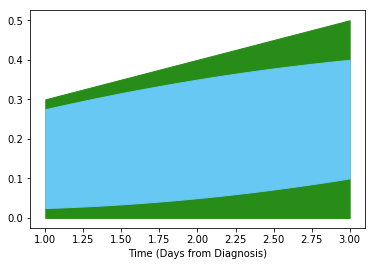

In [81]:
## Alternatively, we can build a phylogeny 
DG_example=nx.DiGraph() 

DG_example.add_edge(0,1)

make_fish(CCF_example, root_node=0,graph=DG_example)

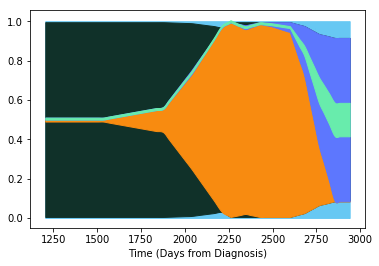

In [99]:
## Sepcfiy time
times_example=[0.3,0.4,0.5]
times = [1204.0, 1533.0, 1878.0, 2037.0, 2212.0, 2261.0, 2345.0, 2429.0, 2492.0, 2599.0, 2681.0, 2765.0, 2856.0, 2940.0]

all_times = [1204.0, 1232.0, 1260.0, 1288.0, 1344.0, 1372.0, 1401.0, 1435.0, 1449.0, 1477.0, 1505.0, 1533.0, 1568.0, 1624.0, 1652.0, 1708.0, 1736.0, 1767.0, 1777.0, 1792.0, 1805.0, 1831.0, 1834.0, 1878.0, 1907.0, 1997.0, 2037.0, 2074.0, 2102.0, 2135.0, 2137.0, 2165.0, 2212.0, 2250.0, 2254.0, 2261.0, 2262.0, 2264.0, 2269.0, 2275.0, 2282.0, 2288.0, 2296.0, 2303.0, 2310.0, 2316.0, 2345.0, 2373.0, 2401.0, 2429.0, 2457.0, 2492.0, 2499.0, 2513.0, 2541.0, 2569.0, 2583.0, 2591.0, 2599.0, 2600.0, 2603.0, 2606.0, 2613.0, 2621.0, 2625.0, 2653.0, 2681.0, 2709.0, 2737.0, 2765.0, 2793.0, 2821.0, 2856.0, 2883.0, 2912.0, 2940.0]

make_fish(inter_CCF,graph = DG,root_node=1, times= all_times)


[2.4999999999999996]
[2.4999999999999996, 10.000000000000004]
[2.4999999999999996, 10.000000000000004, 16.0]
[12.5]
[12.5, 30.0]
[12.5, 30.0, 24.0]


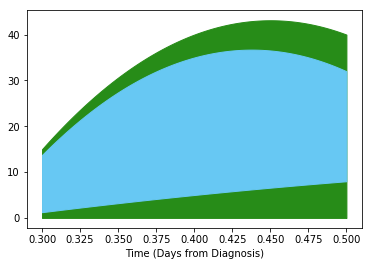

In [82]:
## Specify overall size
wbc_example=[50,100,80]
wbc = [64.46, 19.48, 21.42, 20.14, 51.4, 102.61, 237.38, 356.2, 359.32, 363.47, 148.37, 74.81, 61.58, 105.72]



make_fish(CCF_example,graph = DG_example, times=times_example,wbc=wbc_example, root_node = 0)

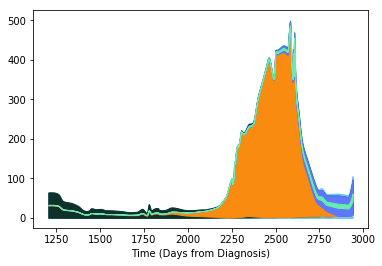

In [101]:
## Specify overall size
wbc_example=[50,100,80]
wbc = [64.46, 19.48, 21.42, 20.14, 51.4, 102.61, 237.38, 356.2, 359.32, 363.47, 148.37, 74.81, 61.58, 105.72]

all_wbc = [64.46, 64.72, 60.87, 42.74, 36.75, 30.9, 20.22, 18.71, 24.53, 22.08, 22.75, 19.48, 19.16, 17.09, 15.22, 15.51, 22.8, 12.85, 35.1, 18.9, 23.13, 24.3, 20.78, 21.42, 26.56, 19.81, 20.14, 21.62, 22.13, 25.26, 25.47, 29.13, 51.4, 100.71, 86.51, 102.61, 108.96, 143.9, 136.12, 170.22, 185.48, 182.46, 201.24, 221.08, 219.82, 216.07, 237.38, 245.08, 311.93, 356.2, 404.05, 359.32, 425.96, 426.92, 436.73, 432.6, 499.33, 398.19, 363.47, 427.45, 374.0, 471.5, 357.72, 306.04, 293.77, 190.94, 148.37, 110.21, 75.93, 74.81, 60.91, 60.98, 61.58, 60.12, 57.44, 105.72]


make_fish(inter_CCF,graph = DG, times=all_times,wbc=all_wbc, root_node = 1)



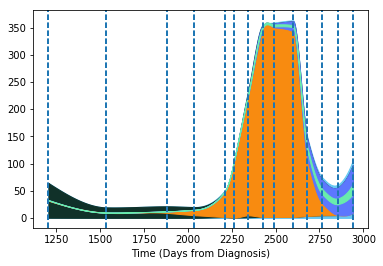

In [94]:
## Add lines at sample points
sample_list = ['JB-0215-T-02_1', 'JB-0215-T-02_2', 'RP-1403_JB-0215-T-03_v1_Exome_OnPrem', 'JB-0215-T-03_1', 'JB-0215-T-03_2', 'RP-1403_JB-0215-TC-04_v1_Exome_OnPrem', 'JB-0215-T-05', 'JB-0215-T-06', 'JB-0215-T-07', 'JB-0215-T-08', 'JB-0215-T-09', 'JB-0215-T-10', 'JB-0215-T-11', 'JB-0215-T-12']

make_fish(CCF,graph=DG,times=times,wbc=wbc,sample_labels=sample_list,root_node=1)

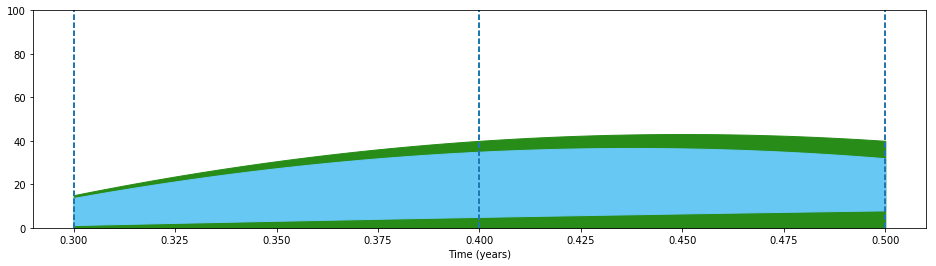

In [74]:
## Change anything 
plt.figure(figsize=(16,4))

make_fish(CCF_example,graph=DG_example,times=times_example,wbc=wbc_example,sample_labels=samples,interp="smooth",root_node =0)

plt.ylim(0,100)
plt.xlabel("Time (years)")


In [ ]:
## to save just savefig as eps (svg works too but export is worse)

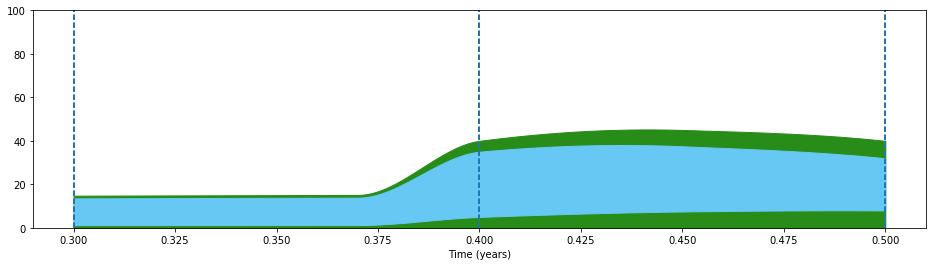

In [117]:
## add whitecounts
plt.figure(figsize=(16,4))

add_wbc=simple_tree(_xvals=[0.35,0.36,0.37,0.45],
                    _data=[45,55,50,100],
                    sorted_=False) 


make_fish(CCF_example,graph=DG_example,times=times_example,wbc=wbc_example,add_wbc=add_wbc,sample_labels=samples,interp="smooth",
          smooth_hack=True)  ### <-- if adding white count points that do not overlap the measured points, set this to True. 
plt.ylim(0,100)
plt.xlabel("Time (years)")
# plt.scatter(simple_tree._xvals,simple_tree._data)


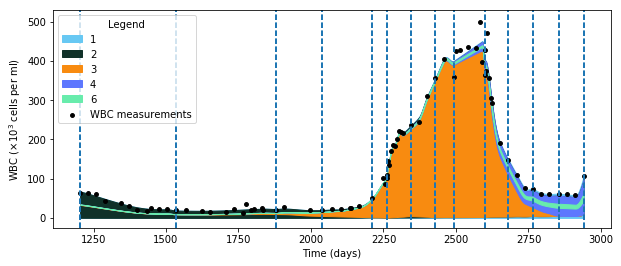

In [141]:
plt.figure(figsize=(10,4))

add_wbc=simple_tree(_xvals=[1232.0,
 1260.0,
 1288.0,
 1344.0,
 1372.0,
 1401.0,
 1435.0,
 1449.0,
 1477.0,
 1505.0,
 1568.0,
 1624.0,
 1652.0,
 1708.0,
 1736.0,
 1767.0,
 1777.0,
 1792.0,
 1805.0,
 1831.0,
 1834.0,
 1907.0,
 1997.0,
 2074.0,
 2102.0,
 2135.0,
 2137.0,
 2165.0,
 2250.0,
 2254.0,
 2262.0,
 2264.0,
 2269.0,
 2275.0,
 2282.0,
 2288.0,
 2296.0,
 2303.0,
 2310.0,
 2316.0,
 2373.0,
 2401.0,
 2457.0,
 2499.0,
 2513.0,
 2541.0,
 2569.0,
 2583.0,
 2591.0,
 2600.0,
 2603.0,
 2606.0,
 2613.0,
 2621.0,
 2625.0,
 2653.0,
 2709.0,
 2737.0,
 2793.0,
 2821.0,
 2883.0,
 2912.0],
_data=[64.72,
 60.87,
 42.74,
 36.75,
 30.9,
 20.22,
 18.71,
 24.53,
 22.08,
 22.75,
 19.16,
 17.09,
 15.22,
 15.51,
 22.8,
 12.85,
 35.1,
 18.9,
 23.13,
 24.3,
 20.78,
 26.56,
 19.81,
 21.62,
 22.13,
 25.26,
 25.47,
 29.13,
 100.71,
 86.51,
 108.96,
 143.9,
 136.12,
 170.22,
 185.48,
 182.46,
 201.24,
 221.08,
 219.82,
 216.07,
 245.08,
 311.93,
 404.05,
 425.96,
 426.92,
 436.73,
 432.6,
 499.33,
 398.19,
 427.45,
 374.0,
 471.5,
 357.72,
 306.04,
 293.77,
 190.94,
 110.21,
 75.93,
 60.91,
 60.98,
 60.12,
 57.44],
sorted_=False) 


make_fish(CCF,graph=DG,times=times,wbc=wbc,add_wbc=add_wbc,sample_labels=sample_list,interp="smooth",root_node =1,
          smooth_hack=True)  ### <-- if adding white count points that do not overlap the measured points, set this to True. 
# plt.ylim(0,100)
plt.xlabel("Time (days)")
plt.ylabel(r"WBC ($\times 10^3$ cells per ml)")
plt.scatter(add_wbc._xvals,add_wbc._data, c= 'black', s= 15, label ='WBC measurements')
plt.legend(loc='best', title='Legend')

In [1]:
wbc_3 = [0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.021159420289855072,
  0.03901449275362319,
  0.04794202898550725,
  0.06579710144927536,
  0.07472463768115942,
  0.08460869565217391,
  0.08779710144927536,
  0.09257971014492754,
  0.09672463768115942,
  0.10501449275362319,
  0.10597101449275362,
  0.12,
  0.18566037735849056,
  0.38943396226415095,
  0.48,
  0.5772571428571428,
  0.6508571428571428,
  0.7376,
  0.7428571428571429,
  0.8164571428571428,
  0.94,
  0.9787755102040816,
  0.9828571428571429,
  0.99,
  0.9894047619047619,
  0.9882142857142857,
  0.9852380952380952,
  0.9816666666666667,
  0.9775,
  0.9739285714285714,
  0.9691666666666666,
  0.965,
  0.9608333333333333,
  0.9572619047619048,
  0.94,
  0.9533333333333333,
  0.9666666666666667,
  0.98,
  0.9755555555555555,
  0.97,
  0.96803738317757,
  0.9641121495327103,
  0.9562616822429906,
  0.948411214953271,
  0.9444859813084112,
  0.9422429906542056,
  0.94,
  0.9370731707317073,
  0.9282926829268292,
  0.9195121951219511,
  0.8990243902439023,
  0.8756097560975609,
  0.8639024390243902,
  0.781951219512195,
  0.7,
  0.5666666666666667,
  0.4333333333333333,
  0.3,
  0.20769230769230768,
  0.11538461538461536,
  0.0,
  0.0,
  0.0,
  0.0]

In [ ]:
import collections
def make_ccf_grid_from_sample(ccf_dat,n):
    variant_ccf_dict=collections.OrderedDict()
    sample=ccf_dat.sample_list[n]
    ccf_dict={x[0]+1:np.argmax(x[1][n])/100. for x in enumerate(sample.DPresults_ND["clust_CCF_dens"])}
    for variant in sample.concordant_variants:
        variant_ccf_dict[variant]=ccf_dict[variant.cluster_assignment]
    return variant_ccf_dict


In [113]:
def make_scatter(ccf_dat):
    scatter_vals_x=[]
    scatter_vals_y=[]
    scatter_vals_c=[]
    scatter_vals_s=[]

    gene_headers=[]
    sample_headers=[]
    phylo_cmap=mcolors.ListedColormap(tableau40)


    for sample_idx in range(len(ccf_dat.sample_list)):
        mut_idx=0
        sample_headers.append(ccf_dat.sample_names[sample_idx])

        for cluster in reversed(range(1,max(ccf_dat.sample_list[0].DPresults_ND["assign"])+1)):
            cluster_muts=0
            for variant,ccf in make_ccf_grid_from_sample(ccf_dat,sample_idx).iteritems():
                if variant.cluster_assignment != cluster:continue

                if variant.gene not in plotter.driver_genes: continue
                if variant.mut_category == "Silent": continue
                

                scatter_vals_x.append(sample_idx+0.5)
                scatter_vals_y.append(mut_idx+0.5)
                scatter_vals_s.append(ccf)
                scatter_vals_c.append(cluster-1)
                mut_idx+=1
                if sample_idx==0:
                    gene_headers.append(str(variant)[:15])
                cluster_muts+=1
             
            for variant,ccf in make_ccf_grid_from_sample(ccf_dat,sample_idx).iteritems():
                if cluster_muts >= 3:continue
                    
                if variant.gene in plotter.driver_genes and  variant.mut_category != "Silent": continue
                if variant.cluster_assignment != cluster:continue
                

                scatter_vals_x.append(sample_idx+0.5)
                scatter_vals_y.append(mut_idx+0.5)
                scatter_vals_s.append(ccf)
                scatter_vals_c.append(cluster-1)
                mut_idx+=1
                if sample_idx==0:
                    gene_headers.append(str(variant)[:15])
                cluster_muts+=1

    scatter_matrix=zip(scatter_vals_x,scatter_vals_y,scatter_vals_c,scatter_vals_s)

    #plt.xticks([x+0.5 for x in range( len(plot_array[0]))],[header.keys()[x] for x in index_tumor],rotation=90)
    #plt.yticks([x+0.5 for x in range( len(plot_array))],[gene_headers.keys()[x] for x in reversed(index_gene)], fontsize=9, fontweight='bold')
    fig3 = plt.figure(figsize=[len(sample_headers)/2.+.5, len(gene_headers)/3.5+0.35])
    scatter_vals_s=np.array(scatter_vals_s)
    scatter_vals_s=scatter_vals_s/max(scatter_vals_s)

    plt.scatter(np.array(scatter_vals_x),np.array(scatter_vals_y),
                c=[phylo_cmap.colors[x] for x in scatter_vals_c],
                s=np.array(scatter_vals_s)*75,
                marker="s", 
                facecolors=True,
                edgecolor='none'
               )

    #plt.ylim(-0.1, max(scatter_vals_y)+0.1)
    #plt.xlim(-0.1,  max(scatter_vals_x)+0.1)

    plt.xticks([x+0.5 for x in range( len(sample_headers))],sample_headers,rotation=90, fontweight='bold')
    plt.yticks([x+0.5 for x in range( len(gene_headers))],gene_headers, fontsize=9, fontweight='bold')
    plt.gca().set_frame_on(0)


    return fig3


